# Word Embedding example
 - 단어를 벡터로 표현하는 방법
> - https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/word2vec/
- http://solarisailab.com/archives/374

---
## Tensorflow로 직접 만들기

In [4]:
# -*- coding: utf-8 -*-

# 절대 임포트 설정
from __future__ import absolute_import
from __future__ import print_function

# 필요한 라이브러리들을 임포트
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Step 1: 필요한 데이터를 다운로드한다.
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """파일이 존재하지 않으면 다운로드하고 사이즈가 적절한지 체크한다."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('corpus/text8.zip', 31344016)

# 문자열로 데이터를 읽는다
def read_data(filename):
  """zip파일 압축을 해제하고 단어들의 리스트를 읽는다."""
  with zipfile.ZipFile(filename) as f:
    data = f.read(f.namelist()[0]).split()
  return data

words = read_data(filename)
print('Data size', len(words))

Found and verified corpus/text8.zip
Data size 17005207


In [3]:
# Step 2: dictionary를 만들고 UNK 토큰을 이용해서 rare words를 교체(replace)한다.
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], (b'the', 1061396), (b'of', 593677), (b'and', 416629), (b'one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] [b'anarchism', b'originated', b'as', b'a', b'term', b'of', b'abuse', b'first', b'used', b'against']


In [4]:
# Step 3: skip-gram model을 위한 트레이닝 데이터(batch)를 생성하기 위한 함수.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 b'originated' -> 5234 b'anarchism'
3081 b'originated' -> 12 b'as'
12 b'as' -> 3081 b'originated'
12 b'as' -> 6 b'a'
6 b'a' -> 12 b'as'
6 b'a' -> 195 b'term'
195 b'term' -> 6 b'a'
195 b'term' -> 2 b'of'


In [5]:
# Step 4: skip-gram model 만들고 학습시킨다.

batch_size = 128
embedding_size = 128  # embedding vector의 크기.
skip_window = 1       # 윈도우 크기 : 왼쪽과 오른쪽으로 얼마나 많은 단어를 고려할지를 결정.
num_skips = 2         # 레이블(label)을 생성하기 위해 인풋을 얼마나 많이 재사용 할 것인지를 결정.

# sample에 대한 validation set은 원래 랜덤하게 선택해야한다. 하지만 여기서는 validation samples을 
# 가장 자주 생성되고 낮은 숫자의 ID를 가진 단어로 제한한다.
valid_size = 16     # validation 사이즈.
valid_window = 100  # 분포의 앞부분(head of the distribution)에서만 validation sample을 선택한다.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # sample에 대한 negative examples의 개수.

graph = tf.Graph()

with graph.as_default():

  # 트레이닝을 위한 인풋 데이터들
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # embedding vectors 행렬을 랜덤값으로 초기화
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # 행렬에 트레이닝 데이터를 지정
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # NCE loss를 위한 변수들을 선언
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # batch의 average NCE loss를 계산한다.
  # tf.nce_loss 함수는 loss를 평가(evaluate)할 때마다 negative labels을 가진 새로운 샘플을 자동적으로 생성한다.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # SGD optimizer를 생성한다.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # minibatch examples과 모든 embeddings에 대해 cosine similarity를 계산한다.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

In [6]:
# Step 5: 트레이닝을 시작한다.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # 트레이닝을 시작하기 전에 모든 변수들을 초기화한다.
  tf.initialize_all_variables().run()
  print("Initialized")

  average_loss = 0
  for step in tqdm(xrange(num_steps)):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # optimizer op을 평가(evaluating)하면서 한 스텝 업데이트를 진행한다.
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # 평균 손실(average loss)은 지난 2000 배치의 손실(loss)로부터 측정된다.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # nearest neighbors의 개수
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized


A Jupyter Widget

Average loss at step  0 :  260.021240234375
Nearest to b'he': b'akhenaten', b'wolfgang', b'genealogies', b'inflections', b'overbeck', b'atchison', b'prosperity', b'sole',
Nearest to b'six': b'depart', b'adin', b'sector', b'brighter', b'transactional', b'tinged', b'acetaldehyde', b'extent',
Nearest to b'had': b'elf', b'waterfall', b'hampering', b'rates', b'parkland', b'neuralgia', b'casa', b'segregationist',
Nearest to b'so': b'azeri', b'souk', b'vertex', b'ancestral', b'synthesizer', b'autonomously', b'curtailing', b'jacobs',
Nearest to b'may': b'thrace', b'improperly', b'maneuverable', b'kilt', b'northampton', b'painterly', b'hatches', b'juggernaut',
Nearest to b'three': b'flamingo', b'soteriology', b'conceals', b'polskiej', b'sierra', b'kaye', b'gn', b'weicker',
Nearest to b'however': b'truman', b'judo', b'discarding', b'romanized', b'mckean', b'nestor', b'strengthened', b'caxton',
Nearest to b'people': b'ustawa', b'urdu', b'abductions', b'synchronous', b'atomism', b'incas', b'deluxe

KeyboardInterrupt: 

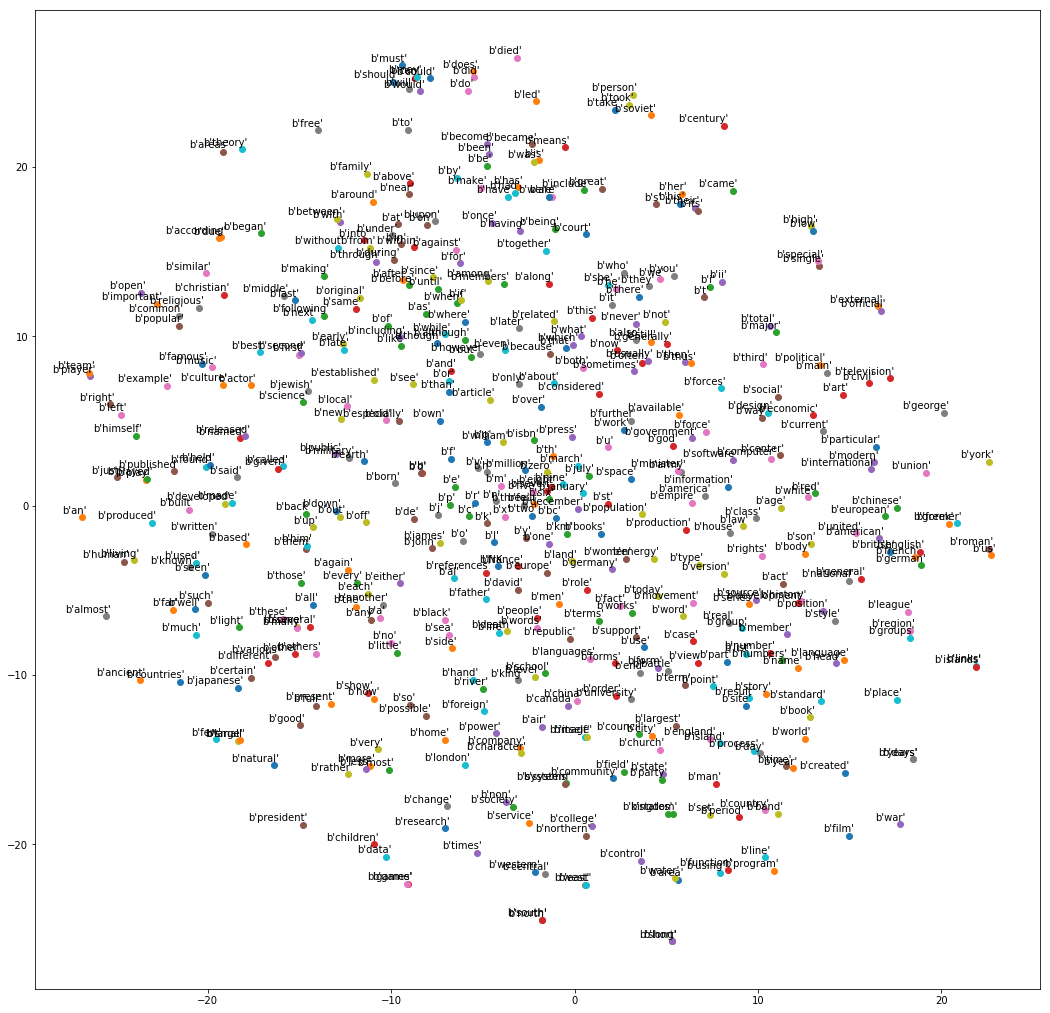

In [8]:
# Step 6: embeddings을 시각화한다.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.show() # 파일로 저장하려면 이 줄 주석처리 후 아랫줄 주석해제 
#   plt.savefig(filename)

try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn and matplotlib to visualize embeddings.")

---
## Use Gensim library
> - https://radimrehurek.com/gensim/models/word2vec.html

In [7]:
"""import nltk
# Download ancillary nltk packages if not already installed
nltk.download('stopwords')"""

from nltk.corpus import stopwords, brown
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm_notebook as tqdm

In [12]:
# stopwords 셋팅
stops = stopwords.words('english')

# stemmer 셋팅
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [7]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [9]:
# nltk brown corpus 가져오기
sentences = []

# 원하는 코퍼스만 지정해서 가져올 경우  
# sentences = brown.sents(categories='fiction')
# sentences += brown.sents(categories='adventure')
# sentences += brown.sents(categories='romance')

# 모든 코퍼스 한번에 가져올 경우
for c in tqdm(brown.categories()):
    sentences += brown.sents(categories=c)

print(len(sentences))

A Jupyter Widget

57340


In [10]:
sentences[:10]

[['Dan',
  'Morgan',
  'told',
  'himself',
  'he',
  'would',
  'forget',
  'Ann',
  'Turner',
  '.'],
 ['He', 'was', 'well', 'rid', 'of', 'her', '.'],
 ['He',
  'certainly',
  "didn't",
  'want',
  'a',
  'wife',
  'who',
  'was',
  'fickle',
  'as',
  'Ann',
  '.'],
 ['If',
  'he',
  'had',
  'married',
  'her',
  ',',
  "he'd",
  'have',
  'been',
  'asking',
  'for',
  'trouble',
  '.'],
 ['But', 'all', 'of', 'this', 'was', 'rationalization', '.'],
 ['Sometimes',
  'he',
  'woke',
  'up',
  'in',
  'the',
  'middle',
  'of',
  'the',
  'night',
  'thinking',
  'of',
  'Ann',
  ',',
  'and',
  'then',
  'could',
  'not',
  'get',
  'back',
  'to',
  'sleep',
  '.'],
 ['His',
  'plans',
  'and',
  'dreams',
  'had',
  'revolved',
  'around',
  'her',
  'so',
  'much',
  'and',
  'for',
  'so',
  'long',
  'that',
  'now',
  'he',
  'felt',
  'as',
  'if',
  'he',
  'had',
  'nothing',
  '.'],
 ['The',
  'easiest',
  'thing',
  'would',
  'be',
  'to',
  'sell',
  'out',
  'to',
  'A

In [13]:
# 비단어 모두 제외하는 정규식을 이용한 토크나이저 
t = RegexpTokenizer("[A-Za-z]+")

# 그냥 비문자 제거하고 소문자화만
tokenized = []
for sentence in tqdm(sentences):
    tokenized.append(t.tokenize(' '.join([w.lower() for w in sentence if t not in stops])))

A Jupyter Widget

In [13]:
"""# stopwords 제거 및 stemming
# 데이터가 충분하므로 여기선 굳이 사용안함 
stemmed = []
for sentence in sentences:
    stemmed.append([stemmer.stem(t) for t in sentence if t not in stops])"""

In [14]:
print(sentences[100])
print(tokenized[100])

["We'll", 'work', 'hard', ',', 'Mr.', 'Morgan', "''", '.']
['we', 'll', 'work', 'hard', 'mr', 'morgan']


In [15]:
from gensim import models
# https://radimrehurek.com/gensim/models/word2vec.html

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [94]:
print('데이터가 어떤 포멧으로 들어가는지 아는게 중요')
for i in tokenized[:10]:
    print(i) 

데이터가 어떤 포멧으로 들어가는지 아는게 중요
['dan', 'morgan', 'told', 'himself', 'he', 'would', 'forget', 'ann', 'turner']
['he', 'was', 'well', 'rid', 'of', 'her']
['he', 'certainly', 'didn', 't', 'want', 'a', 'wife', 'who', 'was', 'fickle', 'as', 'ann']
['if', 'he', 'had', 'married', 'her', 'he', 'd', 'have', 'been', 'asking', 'for', 'trouble']
['but', 'all', 'of', 'this', 'was', 'rationalization']
['sometimes', 'he', 'woke', 'up', 'in', 'the', 'middle', 'of', 'the', 'night', 'thinking', 'of', 'ann', 'and', 'then', 'could', 'not', 'get', 'back', 'to', 'sleep']
['his', 'plans', 'and', 'dreams', 'had', 'revolved', 'around', 'her', 'so', 'much', 'and', 'for', 'so', 'long', 'that', 'now', 'he', 'felt', 'as', 'if', 'he', 'had', 'nothing']
['the', 'easiest', 'thing', 'would', 'be', 'to', 'sell', 'out', 'to', 'al', 'budd', 'and', 'leave', 'the', 'country', 'but', 'there', 'was', 'a', 'stubborn', 'streak', 'in', 'him', 'that', 'wouldn', 't', 'allow', 'it']
['the', 'best', 'antidote', 'for', 'the', 'bitterness

In [16]:
# word2vec model 1회만 간단히 학습할때
model = models.Word2Vec(tokenized, size=100, window=7, min_count=5)

In [23]:
%%time
# 너무 sparse하면 또 학습이 잘 안됨 100~300정도가 적당...
# alpha (float) – The initial learning rate.
# min_alpha (float) – Learning rate will linearly drop to min_alpha as training progresses.
size=100
model = models.Word2Vec(size=size, window=7, min_count=3, workers=8, alpha=0.025, min_alpha=0.01)

model.build_vocab(tokenized) # 오로지 한번만 스트럭팅 가능

# learning_rate를 낮춰가며 여러번 트레이닝
for epoch in tqdm(range(10)):
    if epoch%1 ==0:
        print('epoch:',epoch, 'train completed')
    model.train(tokenized, total_examples=model.corpus_count, epochs=model.epochs)

A Jupyter Widget

epoch: 0 train completed
epoch: 1 train completed
epoch: 2 train completed



Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch: 3 train completed
epoch: 4 train completed
epoch: 5 train completed
epoch: 6 train completed
epoch: 7 train completed
epoch: 8 train completed
epoch: 9 train completed

Wall time: 19.8 s


In [24]:
# model['good']
model.wv.get_vector('good')

array([-2.4681365 , -1.388839  ,  0.89232314,  0.17053704,  0.4538503 ,
       -1.3155988 , -1.2026201 ,  0.13066876,  0.57681894, -1.4458882 ,
        0.06322006,  3.42725   , -0.20068619, -0.1744332 , -1.3782598 ,
        2.7396538 , -0.6407544 , -1.8296157 , -0.856005  , -0.81839556,
        0.50275975,  0.3592694 , -0.15001044, -1.2192867 ,  0.77562857,
        0.5425313 , -0.07206844, -0.461729  , -0.32742822, -1.7354505 ,
        2.3031917 , -3.0466154 ,  0.1147335 , -0.83939284, -0.12996507,
       -0.3560425 , -0.10547101, -0.0906778 ,  1.3318812 , -2.525733  ,
       -0.5054406 , -2.3249278 ,  2.0505438 ,  0.6739518 , -0.79937327,
        2.1105456 ,  1.9323221 ,  0.86772645,  0.5952407 ,  1.2602013 ,
        0.04590131, -0.88232493, -0.33647117,  0.53581196,  2.611702  ,
       -0.9157439 , -0.7866572 , -2.0324557 ,  0.4171246 , -1.3287013 ,
       -0.30920285, -1.3952813 , -0.10905346,  2.6204293 , -1.0596747 ,
       -0.6755531 , -3.2587254 , -1.7951669 ,  1.4298253 , -0.77

In [25]:
# model.most_similar('cup')
model.wv.most_similar('cup')

[('butter', 0.6424869298934937),
 ('onion', 0.6284375190734863),
 ('dregs', 0.6243026256561279),
 ('vinegar', 0.576816201210022),
 ('powdered', 0.5672318935394287),
 ('minced', 0.5665478110313416),
 ('teaspoon', 0.5632758140563965),
 ('pickled', 0.5632333755493164),
 ('tablespoonful', 0.5569989681243896),
 ('flour', 0.5534971952438354)]

In [26]:
# model.wv.most_similar(positive=['woman', 'he'], negative=['man'])
model.wv.most_similar(positive=['king', 'woman'], negative=['man'])

[('princess', 0.5053368806838989),
 ('engagement', 0.46609795093536377),
 ('eleanor', 0.4120939373970032),
 ('prettiest', 0.40933671593666077),
 ('marriage', 0.38965684175491333),
 ('lalaurie', 0.3817104697227478),
 ('szold', 0.3735703229904175),
 ('lovely', 0.37228429317474365),
 ('youngest', 0.36905577778816223),
 ('baton', 0.3688749074935913)]

In [22]:
# model.similarity('mother', 'father')

# model.wv.similarity('mother', 'father')
model.wv.similarity('king', 'queen')

0.9565487607623786

---
## 한국어 embedding
- Naver movie review 
> - https://github.com/e9t/nsmc
 - https://datascienceschool.net/view-notebook/6927b0906f884a67b0da9310d3a581ee/
 - http://konlpy-ko.readthedocs.io

In [1]:
import csv
from pprint import pprint

# tsv load
with open('corpus/naver_movie_corpus/ratings_train.txt', 'r', encoding='utf-8') as f:
    rdr = csv.reader(f, delimiter='\t')
    naver_train = list(rdr)
    naver_train = [s[1] for s in naver_train[1:]]
    
with open('corpus/naver_movie_corpus/ratings_test.txt', 'r', encoding='utf-8') as f:
    rdr = csv.reader(f, delimiter='\t')
    naver_test = list(rdr)
    naver_test = [s[1] for s in naver_test[1:]]

pprint(naver_train[310])

['패션에 대한 열정! 안나 윈투어!',
 '키이라 나이틀리가 연기하고자 했던건 대체 정신장애일까 틱장애일까',
 '허허...원작가 정신나간 유령이라... 재미있겠네요!',
 '포스터는 있어보이는데 관객은 114명이네',
 '이 영화가 왜 이렇게 저평가 받는지 모르겠다',
 '단순하면서 은은한 매력의 영화',
 "'다 알바생인가 내용도 없고 무서운거도 없고 웃긴거도 하나도 없음 완전 별싱거운 영화.ㅇ.ㅇ내ㅇ시간 넘 아까움 .. . 완전 낚임",
 '오게두어라! 서리한이 굶주렸다!',
 '정말 맘에 들어요. 그래서 또 보고싶은데 또 보는 방법이 없네? >.. ㅜㅡ',
 '윤제문이라는 멋진 배우를 발견하게 됐어요. 소소한 일탈이 잔잔한 미소를 머금게 합니다. 음악은 조금 아쉽네요ㅠㅠ 8점 주고 싶은데 평점 '
 '올리고 싶어 10점 줄게요^^',
 '평점에속지마시길시간낭비 돈낭비임',
 '리얼리티가 뛰어나긴 한데 큰 공감은 안간다. 이민기캐릭터는 정신의학상 분노조절장애 초기 증상일거다. 툭하면 사람패고 욕하고 물건 '
 '파손하고.. 조금 오바였음. 극 초반엔 신선했는데 가면 갈수록 이민기 정신상태 공감불가.',
 '마이너스는 왜없냐 ㅋ 뮤비 보고 영화수준 딱 알만하더군 ㅉㅉ 북한에서 이런거 만들라고 돈 대주던?',
 '난 우리영화를 사랑합니다....^^;',
 '데너리스 타르 가르엔...나도 용의주인이 되고 싶다...누이랑,근친상간이나 하고 다닐지라도,소설 속에선 제일 멋진 놈이 자이메 '
 '라니스터였는데,드라마속에선,드래곤(용)이 제일 멋지네(웃음)감독님 토르-2 다크 월드는 말아 잡수셨을지라도,기본 선방은 했음']


In [2]:
len(naver_train)

150000

In [12]:
# pos tagging, tokenizing
from konlpy.tag import Twitter
tagger = Twitter()

# *****pos tagging에 시간 좀 걸립니다******
def tokenize(doc):
    return ['/'.join(t) for t in tagger.pos(doc, norm=True, stem=True)]

sentences=[]
for d in tqdm(naver_train[:10000]):
# for d in tqdm(naver_train):
    sentences.append(tokenize(d))

A Jupyter Widget

In [13]:
print('문장 총 개수: ', len(sentences))
for i in range(5):
    print(sentences[i])

문장 총 개수:  10000
['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증/Noun', '나다/Verb', '목소리/Noun']
['흠/Noun', '.../Punctuation', '포스터/Noun', '보고/Noun', '초딩/Noun', '영화/Noun', '줄/Noun', '..../Punctuation', '오버/Noun', '연기/Noun', '조차/Josa', '가볍다/Adjective', '않다/Verb']
['너무/Noun', '재/Noun', '밓었/Noun', '다/Josa', '그래서/Adverb', '보다/Verb', '추천/Noun', '하다/Verb']
['교도소/Noun', '이야기/Noun', '구먼/Noun', '../Punctuation', '솔직하다/Adjective', '재미/Noun', '는/Josa', '없다/Adjective', '../Punctuation', '평점/Noun', '조정/Noun']
['사이몬페그/Noun', '의/Josa', '익살/Noun', '스런/Josa', '연기/Noun', '가/Josa', '돋보이다/Verb', '영화/Noun', '!/Punctuation', '스파이더맨/Noun', '에서/Josa', '늙다/Verb', '보이다/Verb', '하다/Verb', '크다/Verb', '스틴/Noun', '던스트/Noun', '가/Josa', '너무나/Noun', '도/Josa', '이쁘다/Adjective', '보이다/Verb']


In [14]:
from gensim import models

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [16]:
%%time
size=100
model = models.Word2Vec(size=size, window=7, min_count=5, workers=8,alpha=0.025, min_alpha=0.02)

model.build_vocab(sentences) # 오로지 한번만 스트럭팅 가능

# learning_rate를 낮춰가며 여러번 트레이닝
for epoch in tqdm(range(10)):
    if epoch%1 ==0:
        print('epoch:',epoch, 'train completed')
    model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

A Jupyter Widget

epoch: 0 train completed
epoch: 1 train completed
epoch: 2 train completed
epoch: 3 train completed
epoch: 4 train completed
epoch: 5 train completed
epoch: 6 train completed
epoch: 7 train completed
epoch: 8 train completed
epoch: 9 train completed

Wall time: 2.96 s


In [20]:
# model['재미/Noun'] # 이렇게 써도 된다. 그러나 deprecated
model.wv.get_vector('재미/Noun')

array([ 5.6769186e-01, -8.7863326e-01, -1.1114942e+00, -5.3915864e-01,
       -6.4639962e-01, -1.0249050e+00, -3.3270895e+00, -2.0925064e+00,
        4.4127867e-01,  1.9555621e-02,  2.6331112e+00, -1.6795123e+00,
       -4.4497337e+00, -5.0582290e-01,  7.0052761e-01,  3.1059690e+00,
       -3.9896340e+00, -7.3392022e-01,  4.6950307e+00,  6.2188858e-01,
        5.6376696e-01, -1.5524213e-01,  1.0583447e-03, -1.6092123e+00,
        3.9201364e-01,  4.2379230e-01, -3.8275138e-01,  7.4202198e-01,
        1.9099727e+00, -5.5913323e-01, -8.6941481e-02, -1.8704506e+00,
        1.4951499e-01,  4.1127837e-01,  1.1907973e+00, -2.1392181e+00,
       -1.6533275e+00, -8.2467204e-01,  8.1894565e-01, -1.2188519e+00,
        9.0737587e-01, -1.6575266e+00,  2.0618329e+00,  8.5048532e-01,
       -3.8348332e-01, -9.7651237e-01, -1.2584143e+00, -3.8698938e+00,
       -1.0130836e+00, -1.8005094e-01,  3.0625468e-01,  1.1620649e-01,
        2.2027034e-01, -8.9646363e-01,  1.5916374e+00,  1.5797921e+00,
      

In [21]:
print('vocab 총 개수:', len(model.wv.vocab))
model.wv.vocab

vocab 총 개수: 2885


{'아/Exclamation': <gensim.models.keyedvectors.Vocab at 0x27769c6cfd0>,
 '더빙/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c6ccc0>,
 '../Punctuation': <gensim.models.keyedvectors.Vocab at 0x27769c6ca58>,
 '진짜/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c6ceb8>,
 '짜증/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c6ce48>,
 '나다/Verb': <gensim.models.keyedvectors.Vocab at 0x2776881a2b0>,
 '목소리/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c790b8>,
 '흠/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c79080>,
 '.../Punctuation': <gensim.models.keyedvectors.Vocab at 0x27769c79048>,
 '포스터/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c79a58>,
 '보고/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c79a90>,
 '초딩/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c79ac8>,
 '영화/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c79b00>,
 '줄/Noun': <gensim.models.keyedvectors.Vocab at 0x27769c79b38>,
 '..../Punctuation': <gensim.models.keyedvectors.Vocab at 0x27769c79b

In [27]:
# model.wv.most_similar('재미/Noun')
model.wv.most_similar('은/Noun')

[('점/Noun', 0.43993526697158813),
 ('억/Noun', 0.4261243939399719),
 ('점준/Noun', 0.42571571469306946),
 ('멍/Noun', 0.4212082624435425),
 ('콜린/Noun', 0.3696920871734619),
 ('분만/Noun', 0.359813392162323),
 ('점줌/Noun', 0.35809269547462463),
 ('류/Noun', 0.35532906651496887),
 ('호/Noun', 0.3464564085006714),
 ('밤/Noun', 0.3406261205673218)]

In [29]:
# model.wv.most_similar(positive=['엄마/Noun', '남자/Noun'], negative=['여자/Noun'])
model.wv.most_similar(positive=['왕자/Noun', '남자/Noun'], negative=['여자/Noun'])

[('달리/Noun', 0.37996822595596313),
 ('조합/Noun', 0.35837322473526),
 ('고독/Noun', 0.3463081121444702),
 ('세트/Noun', 0.34256529808044434),
 ('녹화/Noun', 0.3343202769756317),
 ('교수/Noun', 0.3340764045715332),
 ('역작/Noun', 0.33032310009002686),
 ('섹시/Noun', 0.31497812271118164),
 ('건가/Noun', 0.3071070909500122),
 ('무대/Noun', 0.3060150742530823)]

In [30]:
model.wv.similarity('가족/Noun', '친척/Noun')

KeyError: "word '친척/Noun' not in vocabulary"